### Loading Data From File

In [ ]:
# pip install dgl dglgo -f https://data.dgl.ai/wheels/repo.html

In [ ]:
import torch 
import networkx as nx
import numpy as np
import scipy.sparse as sp
import dgl
import random

#Seeds
dgl.seed(42)
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [ ]:
PATH_TO_GRAPH_FILE = "Cit-HepTh.txt"
graphAdjList = []
with open(PATH_TO_GRAPH_FILE, 'r') as f:
    L = f.readlines()
    for line_ in L:
        if "#" in line_:
            continue 
        src, dst = map(lambda x: int(x), line_.strip().split('\t'))
        graphAdjList.append([src,dst])

### Loading Data into NetworkX

In [ ]:
nx_g = nx.DiGraph()
nx_g.add_edges_from(graphAdjList)

paper_to_node = {node:index for index, node in enumerate(sorted(nx_g.nodes())) }
node_to_paper = {v:k for k, v in paper_to_node.items()}

### Loading Data Into DGL

In [ ]:
print(torch.cuda.is_available())
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")
print("Using device:", device)

False
Using device: cpu


In [ ]:
g = dgl.from_networkx(nx_g).to(device)

### Model Constants

In [ ]:
EMB_SIZE = 20
HIDDEN_DIM_SIZE = 15
FEATURE_TO_USE = 'text' # ['ones','text','ones_text']

### Adding Node Features
- https://docs.dgl.ai/en/0.7.x/guide/graph-feature.html#guide-graph-feature

In [ ]:
import pickle
TEXT_EMBEDDING_FILE = "sentence_transformers_embeddings.pkl"
def get_text_embeddings_in_order(graph_arg):
  with open(TEXT_EMBEDDING_FILE, 'rb') as f:
    loaded_embeddings = pickle.load(f)
  loaded_embeddings = {int(k) : v for k, v in loaded_embeddings.items()} #Convert keys to integer values
  ordered_embeddings = []
  for node in range(graph_arg.number_of_nodes()):
    #Get Paper ID From Node Number
    paper_id = node_to_paper[node]
    ordered_embeddings.append( torch.Tensor(loaded_embeddings[paper_id]) )
  final_embeddings = torch.stack(ordered_embeddings)
  return final_embeddings

#Filling Graphs with All One's
g.ndata['ones'] = torch.ones(g.num_nodes(), EMB_SIZE) 
g.ndata['text'] = get_text_embeddings_in_order(g)

### Training Test Splits
- https://docs.dgl.ai/en/0.7.x/tutorials/blitz/4_link_predict.html#prepare-training-and-testing-sets

In [ ]:
# Split edge set for training and testing
u, v = g.edges()

eids = np.arange(g.number_of_edges())
eids = np.random.permutation(eids)
test_size = int(len(eids) * 0.1)
train_size = g.number_of_edges() - test_size
test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

# Find all negative edges and split them for training and testing
neg_u, neg_v = dgl.sampling.global_uniform_negative_sampling(g, g.number_of_edges())
test_neg_u, test_neg_v = neg_u[:test_size], neg_v[:test_size]
train_neg_u, train_neg_v = neg_u[test_size:], neg_v[test_size:]

In [ ]:
# Removing test edges from graph
train_g = dgl.remove_edges(g, eids[:test_size])

### Defining Model
- https://docs.dgl.ai/en/0.7.x/tutorials/blitz/4_link_predict.html#define-a-graphsage-model

In [ ]:
from dgl.nn import SAGEConv
from torch import nn

class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, h_feats, 'mean')

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

### Creating Pairs of Nodes

In [ ]:
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes())

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())

### Similarity Models

In [ ]:
import dgl.function as fn

class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata['score'][:, 0]

class MLPPredictor(nn.Module):
    def __init__(self, h_feats):
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats)
        self.W2 = nn.Linear(h_feats, 1)

    def apply_edges(self, edges):
        """
        Computes a scalar score for each edge of the given graph.

        Parameters
        ----------
        edges :
            Has three members ``src``, ``dst`` and ``data``, each of
            which is a dictionary representing the features of the
            source nodes, the destination nodes, and the edges
            themselves.

        Returns
        -------
        dict
            A dictionary of new edge features.
        """
        h = torch.cat([edges.src['h'], edges.dst['h']], 1)
        return {'score': self.W2(F.relu(self.W1(h))).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(self.apply_edges)
            return g.edata['score']

### Defining Training Variables

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, RocCurveDisplay
model = GraphSAGE(train_g.ndata[FEATURE_TO_USE].shape[1], HIDDEN_DIM_SIZE).to(device)
# You can replace DotPredictor with MLPPredictor.
pred = MLPPredictor(HIDDEN_DIM_SIZE)
# pred = DotPredictor()

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    fpr, tpr, thresholds = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Link Prediction')
    display.plot()
    return roc_auc

def compute_accuracy(pos_score, neg_score):
    scores = nn.Sigmoid()(torch.cat([pos_score, neg_score]))
    scores[scores < 0.5] = 0
    scores[scores >= 0.5] = 1
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return torch.mean((scores == labels).float()).item()

### Training Loop

/usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In epoch 0, loss: 0.6985003352165222
In epoch 5, loss: 0.6584651470184326
In epoch 10, loss: 0.5871767401695251
In epoch 15, loss: 0.5469152927398682
In epoch 20, loss: 0.5132866501808167
In epoch 25, loss: 0.4835899770259857
In epoch 30, loss: 0.4513896107673645
In epoch 35, loss: 0.4295203685760498
In epoch 40, loss: 0.4202827513217926
In epoch 45, loss: 0.4128238558769226
In epoch 50, loss: 0.40618133544921875
In epoch 55, loss: 0.3988494575023651
In epoch 60, loss: 0.3915781080722809
In epoch 65, loss: 0.389045387506485
In epoch 70, loss: 0.3823312222957611
In epoch 75, loss: 0.37461057305336
In epoch 80, loss: 0.3695172369480133
In epoch 85, loss: 0.3648773729801178
In epoch 90, loss: 0.3612649440765381
In epoch 95, loss: 0.3579707145690918
AUC: 0.8748168647419285 	 Accuracy: 0.7971372008323669


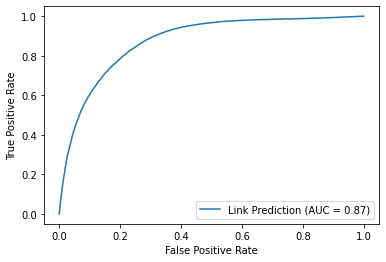

In [ ]:
import itertools
import torch.nn.functional as F
# ----------- 3. set up loss and optimizer -------------- #
# in this case, loss will in training loop
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

# ----------- 4. training -------------------------------- #
all_logits = []
for e in range(100):
    # forward
    h = model(train_g, train_g.ndata[FEATURE_TO_USE])
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e % 5 == 0:
        print('In epoch {}, loss: {}'.format(e, loss))

# ----------- 5. check results ------------------------ #
from sklearn.metrics import roc_auc_score
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    print('AUC:', compute_auc(pos_score, neg_score), '\t', 'Accuracy:', compute_accuracy(pos_score, neg_score))


# Thumbnail credits: Link Prediction with Neo4j, Mark Needham
# sphinx_gallery_thumbnail_path = '_static/blitz_4_link_predict.png'